# Assignment 2 - Image Enhancement and Filtering
# Demonstrations

In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [7]:
def Bilateral_Filter_1(img,n,sigmaS,sigmaR): # Method 1 - Bilateral Filter
    
    gr_f = np.zeros((n,n),dtype=np.float) # creates matrix to store range Gaussian
    gs_f = np.zeros((n,n),dtype=np.float) # creates matrix to store spatial Gaussian component

    a = int((n-1)/2) # (a,a) is the value of the center of the filter, a can be used to adequately walk through the neighborhood of each pixel, with its center placed at the origin, according to n given

    # CREATING FILTER

    #Gaussian Spatial Component
    for x in range(-a,a+1): # values of x and y of each position of an n-sized matrix are needed to calculate euclidean distance from each position to the center
        for y in range(-a,a+1):
            euc = np.sqrt((np.square(x) + np.square(y))) #applies the euclidean distance between the position and the center to find the x value to use in Gaussian kernel equation
            gs_i = float(1) / (2*np.pi*np.square(sigmaS)) #applies the Gaussian kernel equation G(euc,sigmaS) for each pixel of the gaussian spatial component
            gs_i = gs_i * (np.exp( float(-np.square(euc)) / float(( 2*np.square(sigmaS)) ) ) )
            gs_f[x,y] = float(gs_i)

    height, width = img.shape # gets height and width of the original image
    subimg = np.zeros((n,n),dtype=np.float) #creates submatrix to store the current neighborhood of the point being calculated
    result_img = np.zeros(img.shape,dtype=np.uint8) #creates a new empty image with size nxn to store the final image

    #Convolution
    for i in range (a,height-a): # walks through the final image
        for j in range(a,width-a):

            I_f = float(0) # value for the pixel to be calculated is initiated at 0
            W_p = float(0) # normalization factor for the pixel is initiated at 0

            subimg = img[(i-a):(i+a+1), (j-a):(j+a+1)] #gets current submatrix of pixel neighborhood in order to apply filter on it

            for x in range(n): # walks through neighborhood matrix of the current point
                for y in range(n):
                    #Range Gaussian Component
                    dif = float(subimg[x,y]) - float(subimg[a,a])# calculates distance between the current position and the center of the neighborhood matrix, in order to find the x value to use in Gaussian kernel equation
                    gr_i = 1 / (2*np.pi*np.square(sigmaR)) # applies the Gaussian Kernel equation G(dif,sigmaR) for each pixel of the range gaussian component
                    gr_i = gr_i * (np.exp( -np.square(dif) / ( 2*np.square(sigmaR) ) ) )
                    gr_f[x,y] = float(gr_i)

                    w_i = float(gs_f[x,y])*float(gr_f[x,y]) # calculates the value of the filter for each pixel in the neighborhood by multiplying tha range Gaussian and the spatial Gaussian components

                    W_p = W_p + float(w_i) # calculates normalization factor 

                    I_f = I_f + float(w_i*subimg[x,y]) # applies the filter to each point of the neighborhood, by multiplying the filter local value and the neighborhood pixel and summing them all
     
            result_img[i,j] = int(I_f/W_p) # fills up position [x,y] of the final image with the correct number    
    b = int(a/2)
    result_img = np.delete(result_img,np.s_[0:a],0) #removes image padding from original image
    result_img = np.delete(result_img,np.s_[0:a],1)
    result_img = np.delete(result_img,np.s_[height-b-a-1:height-a],0)
    result_img = np.delete(result_img,np.s_[width-b-a-1:width-a],1)

    return result_img

def Laplacian_Filter_2(img,c,kernel): # Method 2 - Unsharp Mask using the Laplacian Filter

    if kernel == 1:
        k = np.matrix([[0,-1,0],[-1,4,-1],[0,-1,0]]) # creates kernel 1
    elif kernel == 2:
        k = np.matrix([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) #creates kernel 2

    height, width = img.shape
    neighborhood = np.zeros((3,3),dtype=np.float) # creates submatrix to store the current neighborhood of the point being calculated
    result_img = np.zeros(img.shape,dtype=np.float) # creates a new empty matrix with the same size as the original image to store the final image
    neigh_pix = 0

    #Convolution with chosen kernel
    for i in range(1,height-1): # walks through the whole image
        for j in range(1,width-1):

            neighborhood = img[(i-1):(i+2),(j-1):(j+2)] # defines the current neighborhood centered in the point i[i,j]
            neighborhood = neighborhood
            img_pixel = 0
            
            for x in range(3): # walks through the current neighborhood calculating the convolution
                for y in range(3):
                    neigh_pix = k[x,y] * neighborhood[x,y]
                    img_pixel = img_pixel  + neigh_pix 
                    
            result_img[i,j] = img_pixel 
    
    result_img = np.delete(result_img,0,0)
    result_img = np.delete(result_img,0,1)  
    result_img = np.delete(result_img,height-2,0)
    result_img = np.delete(result_img,width-2,1) #removes padding of the final image

    img = np.delete(img,0,0)
    img = np.delete(img,0,1)  
    img = np.delete(img,height-2,0)
    img = np.delete(img,width-2,1) #removes padding of the original image temporarily to adequately make operations

    img_min = np.min(result_img) # gets minimum and maximum value of the altered image
    img_max = np.max(result_img)

    result_img = (result_img - img_min)*255/ (img_max - img_min)# scales the final image using normalization (0-255)
    result_img = (c*result_img) + img # adds the filtered image, multiplied by c, back to the original image

    img_min = np.min(result_img) # gets minimum and maximum value of the altered image
    img_max = np.max(result_img)

    result_img = (result_img - img_min)*255/ (img_max - img_min)# scales the final image using normalization (0-255)

    return result_img

def Vignette_Filter_3(img,sigmaRow,sigmaCol): # Method 3 - Vignette Filter
   
    height,width = img.shape

    if height%2 == 0:
        a = int((height/2)-1) #defines centered position of the image
    else:
        a = int((height-1)/2)
    if width%2 == 0:
        b = int((width/2)-1)
    else:
        b = int((width-1)/2)

    gs_row = np.zeros((1,height),dtype=np.float) #creates 1D gaussian kernels
    gs_col = np.zeros((1,width),dtype=np.float)
    result_img = np.zeros((height,width),dtype=np.uint8)

    i = int(0)

    #Gaussian kernel with row size
    for x in range(-a,a+1): # values of x and y of each position of an n-sized matrix are needed to calculate euclidean distance from each position to the center
       gs_x = float(1) / (2*np.pi*np.square(sigmaRow)) #applies the Gaussian kernel equation G(euc,sigmaS) for each pixel of the gaussian spatial component
       gs_x = gs_x * (np.exp( float(-np.square(x)) / float(( 2*np.square(sigmaRow)) ) ) )
       gs_row[0][i] = float(gs_x)
       i = i + 1

    i = 0

    #Gaussian kernel with column size
    for x in range(-b,b+1):
        gs_x = float(1) / (2*np.pi*np.square(sigmaCol)) #applies the Gaussian kernel equation G(euc,sigmaS) for each pixel of the gaussian spatial component
        gs_x = gs_x * (np.exp( float(-np.square(x)) / float(( 2*np.square(sigmaCol)) ) ) )
        gs_col[0][i] = float(gs_x) 
        i = i + 1

    result_img = np.matmul(gs_row.T,gs_col) # matrix product of the row vector transposed and the column vector
    result_img = np.multiply(result_img,img) # multiplies element by element the matrix obtained by the original image

    img_min = np.min(result_img) # gets minimum and maximum value of the altered image
    img_max = np.max(result_img)

    result_img = (result_img - img_min)*255/ (img_max - img_min)# scales the final image using normalization (0-255)

    return result_img.astype(np.uint8)    


## Method 1 - Bilateral Filter
### Example 1

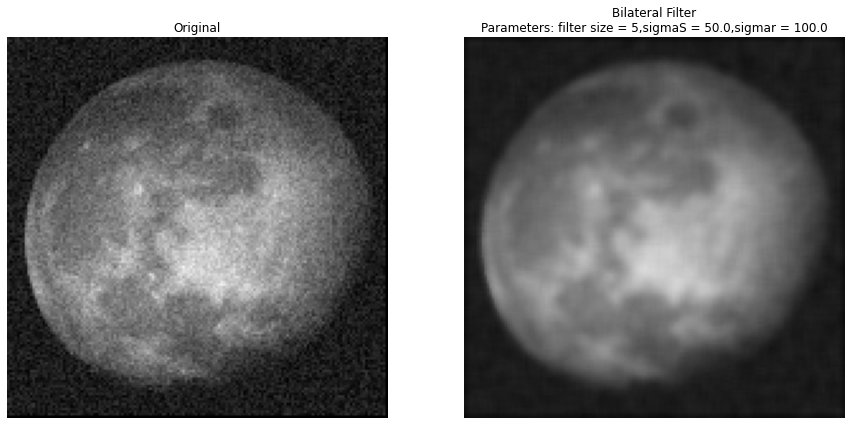

In [15]:
imagename = "imagesasgmt2/moon.png" # reads the name of the reference image file

image = imageio.imread(imagename) # reads the image

height, width = image.shape # gets size of both dimensions of the image

M = int(1) # paramater to indicate the method 1,2, our 3

S = int(0) # parameter to know if the image should be saved, 1 for yes


if M == 1: # Bilateral Filter

    n = int(5) #size of the filter n 

    sigmaS = float(50.0) 

    sigmaR = float(100.0)

    a = int((n-1)/2) # calculates size of the padding required
    image = np.pad(image,(a,a),mode='constant',constant_values=(0)) #adds image padding

    result_img = Bilateral_Filter_1(image,n,sigmaS,sigmaR)

    b = int(a/2)

    image = np.delete(image,np.s_[0:a],0) #removes image padding from original image
    image = np.delete(image,np.s_[0:a],1)
    image = np.delete(image,np.s_[height-b:height+1],0)
    image = np.delete(image,np.s_[width-b:width+1],1)

    result_img = result_img.astype(np.uint8)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(image, cmap="gray", vmin=0,vmax=255); plt.title('Original')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(result_img, cmap="gray", vmin=0, vmax=255); plt.title("Bilateral Filter\nParameters: filter size = 5,sigmaS = 50.0,sigmar = 100.0")
    plt.axis('off')
    

### Example 2

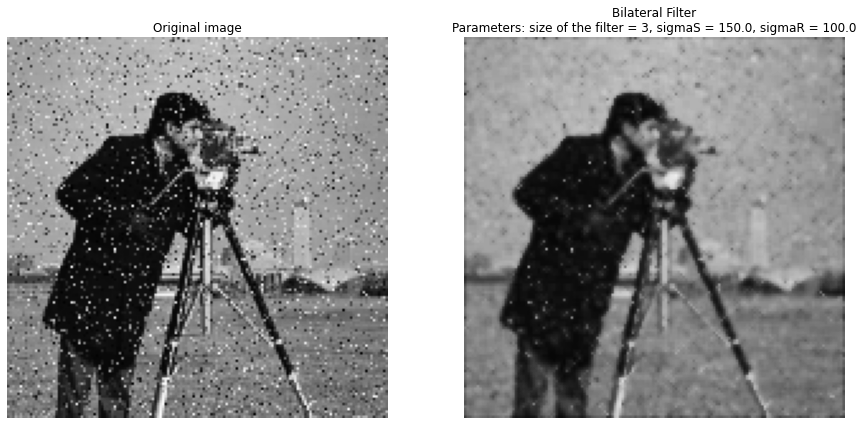

In [14]:
imagename = "imagesasgmt2/camera.png" # reads the name of the reference image file

image = imageio.imread(imagename) # reads the image

height, width = image.shape # gets size of both dimensions of the image

M = int(1) # paramater to indicate the method 1,2, our 3

S = int(0) # parameter to know if the image should be saved, 1 for yes


if M == 1: # Bilateral Filter

    n = int(3) #size of the filter n 

    sigmaS = float(150.0) 

    sigmaR = float(100.0)

    a = int((n-1)/2) # calculates size of the padding required
    image = np.pad(image,(a,a),mode='constant',constant_values=(0)) #adds image padding

    result_img = Bilateral_Filter_1(image,n,sigmaS,sigmaR)

    b = int(a/2)

    image = np.delete(image,np.s_[0:a],0) #removes image padding from original image
    image = np.delete(image,np.s_[0:a],1)
    image = np.delete(image,np.s_[height-b:height+1],0)
    image = np.delete(image,np.s_[width-b:width+1],1)

    result_img = result_img.astype(np.uint8)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(image, cmap="gray", vmin=0,vmax=255); plt.title('Original image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(result_img, cmap="gray", vmin=0, vmax=255); plt.title('Bilateral Filter\nParameters: size of the filter = 3, sigmaS = 150.0, sigmaR = 100.0')
    plt.axis('off')
    

## Method 2 - Unsharp mask using the Laplacian filter
### Examples 1 and 2

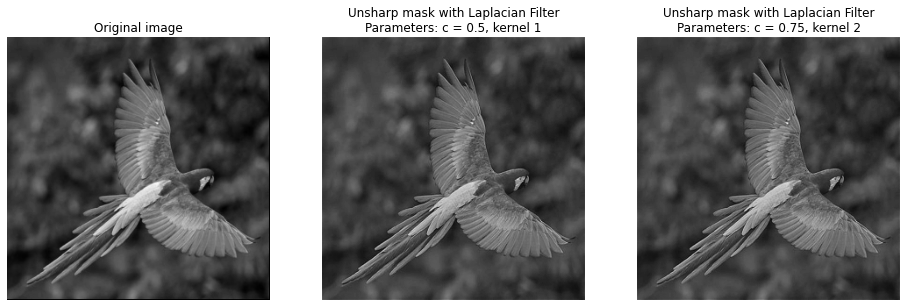

In [17]:
imagename = "imagesasgmt2/arara.png" # reads the name of the reference image file

image = imageio.imread(imagename) # reads the image

height, width = image.shape # gets size of both dimensions of the image

M = int(2) # paramater to indicate the method 1,2, our 3

S = int(0) # parameter to know if the image should be saved, 1 for yes

if M == 2: # Unsharp Mask using the Laplacian Filter

    c = float(0.5)

    kernel = int(1)

    image = np.pad(image,(1,1),mode='constant',constant_values=(0)) #adds image padding
    
    result_img = Laplacian_Filter_2(image,c,kernel) #gets image with filter applied
    result_img2 = Laplacian_Filter_2(image,0.75,2)
    
    image = np.delete(image,0,0) #removes image padding from original image
    image = np.delete(image,0,1)
    image = np.delete(image,height-2,0)
    image = np.delete(image,width-2,1)
    
    plt.figure(figsize=(16,8))
    plt.subplot(131)
    plt.imshow(image, cmap="gray", vmin=0, vmax=255); plt.title("Original image")
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(result_img, cmap="gray", vmin=0, vmax=255); plt.title("Unsharp mask with Laplacian Filter\nParameters: c = 0.5, kernel 1")
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(result_img, cmap ="gray", vmin=0, vmax=255);plt.title("Unsharp mask with Laplacian Filter\nParameters: c = 0.75, kernel 2")
    plt.axis('off')


## Method 3 - Vignette Filter
### Example 1

(-0.5, 249.5, 249.5, -0.5)

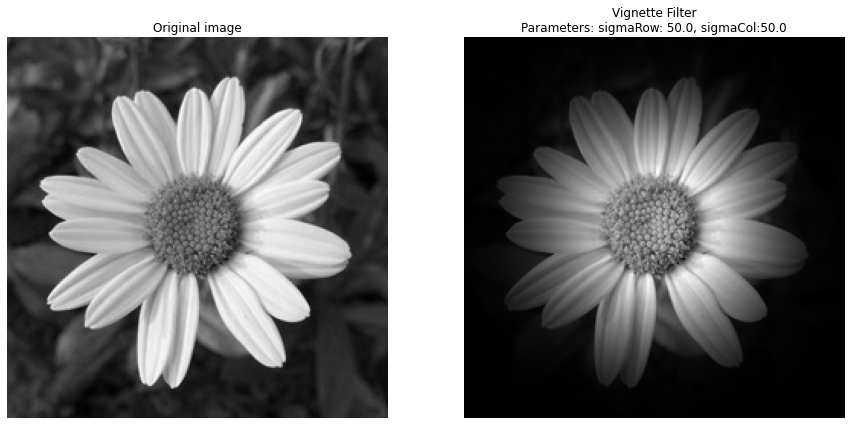

In [19]:
imagename = "imagesasgmt2/flower.png" # reads the name of the reference image file

image = imageio.imread(imagename) # reads the image

height, width = image.shape # gets size of both dimensions of the image

M = int(3) # paramater to indicate the method 1,2, our 3

S = int(0) # parameter to know if the image should be saved, 1 for yes

if M == 3: # Vignette Filter

    sigmaRow = float(50.0)

    sigmaCol = float(50.0)

    result_img = Vignette_Filter_3(image,sigmaRow,sigmaCol)
    
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(image, cmap="gray"); plt.title("Original image")
plt.axis('off')
plt.subplot(122)
plt.imshow(result_img, cmap="gray"); plt.title("Vignette Filter\nParameters: sigmaRow: 50.0, sigmaCol:50.0")
plt.axis('off')


## Example 2

(-0.5, 198.5, 170.5, -0.5)

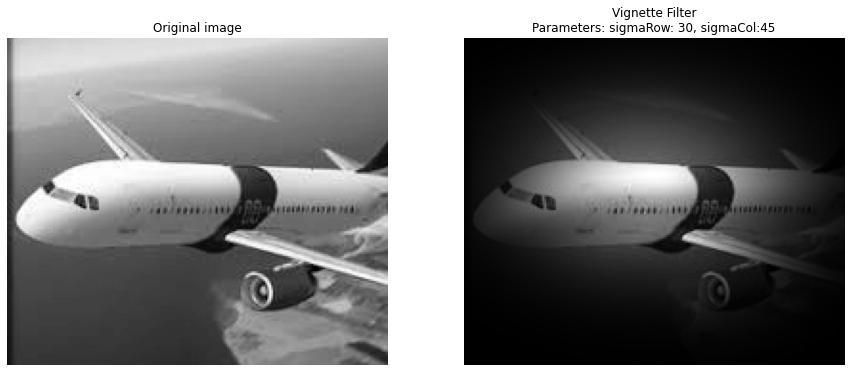

In [21]:
imagename = "imagesasgmt2/airplane.png" # reads the name of the reference image file

image = imageio.imread(imagename) # reads the image

height, width = image.shape # gets size of both dimensions of the image

M = int(3) # paramater to indicate the method 1,2, our 3

S = int(0) # parameter to know if the image should be saved, 1 for yes

if M == 3: # Vignette Filter

    sigmaRow = float(30)

    sigmaCol = float(45)

    result_img = Vignette_Filter_3(image,sigmaRow,sigmaCol)
    
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(image, cmap="gray"); plt.title("Original image")
plt.axis('off')
plt.subplot(122)
plt.imshow(result_img, cmap="gray"); plt.title("Vignette Filter\nParameters: sigmaRow: 30, sigmaCol:45")
plt.axis('off')
